In [354]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, metrics
import xgboost as xgb
import os
import time
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [355]:
# constants
DATA_PATH = '/kaggle/dev/instacart-market-basket-analysis-data/raw_data/'
PREPROCESSED_DATA_PATH = '/kaggle/dev/instacart-market-basket-analysis-data/preprocessed_data/'
SUBMISSIONS_PATH = '/kaggle/dev/instacart-market-basket-analysis-data/submissions/'
MODEL_PERFORMANCE_PATH = '/kaggle/dev/instacart-market-basket-analysis-data/model_performance_data/'

In [356]:
# loading the data
aisles = pd.read_csv(os.path.join(DATA_PATH, 'aisles.csv'))
departments = pd.read_csv(os.path.join(DATA_PATH, 'departments.csv'))
order_products_prior = pd.read_csv(os.path.join(DATA_PATH, 'order_products__prior.csv'))
order_products_train = pd.read_csv(os.path.join(DATA_PATH, 'order_products__train.csv'))
orders = pd.read_csv(os.path.join(DATA_PATH, 'orders.csv'))
products = pd.read_csv(os.path.join(DATA_PATH, 'products.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

In [357]:
order_products = pd.concat([order_products_prior, order_products_train])
assert(len(order_products) == len(order_products_prior) + len(order_products_train))
order_products.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [358]:
prod_catalog = pd.merge(products, departments, on='department_id', how='inner')
prod_catalog = pd.merge(prod_catalog, aisles, on='aisle_id', how='inner')
prod_catalog[10000:10010]

,product_id,product_name,aisle_id,department_id,department,aisle
10000,21092,Organic 100% Pure Dark Amber Maple Syrup,29,13,pantry,honeys syrups nectars
10001,21215,Buzzerkeley Honey,29,13,pantry,honeys syrups nectars
10002,21361,Honey Manuka Raw Kfactor 16,29,13,pantry,honeys syrups nectars
10003,21402,Mango Syrup,29,13,pantry,honeys syrups nectars
10004,21933,Clover Honey Squeeze Bottle,29,13,pantry,honeys syrups nectars
10005,22036,Pure 100% Maple Syrup,29,13,pantry,honeys syrups nectars
10006,22107,Sugar Free Classic Caramel Flavoring Syrup,29,13,pantry,honeys syrups nectars
10007,22139,Dark Corn Syrup,29,13,pantry,honeys syrups nectars
10008,22504,Organic Mountain Forest Amber Honey,29,13,pantry,honeys syrups nectars
10009,22554,Sugar Free Low Calorie Artificially Flavored B...,29,13,pantry,honeys syrups nectars


In [5]:
# Model 1 - Use all previously reordered items per user as next basket
# df1 = pd.merge(prod_catalog, order_products_prior, on='product_id', how='inner')
# df2 = pd.merge(df1, orders, on='order_id', how='inner')
# df2 = df2.sort_values(['user_id', 'order_number', 'order_id', 'add_to_cart_order'])
# print('df2.shape', df2.shape)
# df2 = df2[df2['reordered'] == 1]
# print('df2.shape', df2.shape)
# df3 = pd.merge(sample_submission, orders, on='order_id', how='left')
# df4 = df2[['user_id','product_id']].drop_duplicates()
# df4['product_id'] = df4['product_id'].astype(str)
# df5 = df4.groupby('user_id')['product_id'].agg({'products': lambda x:' '.join(x)}).reset_index()
# df6 = pd.merge(df3, df5, on='user_id', how='left')
# submission_df = df6[['order_id', 'products_y']]
# submission_df.columns = ['order_id', 'products']
# timestamp = str(int(time.time()))
# submission_df.to_csv(SUBMISSIONS_PATH + 'submission-' + timestamp + '.csv', index=False)
# print('Created submission: ' + SUBMISSIONS_PATH + 'submission-' + timestamp + '.csv')

#user_ids = set(orders.user_id.unique())
#orders_per_user_id = orders.groupby('user_id')['order_id'].apply(list).reset_index()
#prior_order_ids = set(orders[orders['eval_set'] == 'prior'].order_id.unique())
#test_order_ids = set(orders[orders['eval_set'] == 'test'].order_id.unique())
#test_orders = orders[orders.order_id.isin(test_order_ids)]
#train_order_products = train_order_products[train_order_products.reordered == 1]

In [265]:
# Create true submission for train set

# Join product ids with space
def products(ids):
    return ' '.join(sorted(ids))

train_order_ids = set(orders[orders['eval_set'] == 'train'].order_id.unique())
train_orders = orders[orders.order_id.isin(train_order_ids)]
train_order_products = pd.merge(train_orders, order_products, on = 'order_id', how = 'left')
train_order_products.product_id = train_order_products.product_id.astype(str)
train_true_submission_df = (train_order_products.groupby('order_id').product_id
                 .agg([products]).reset_index())
train_true_submission_df.to_csv(PREPROCESSED_DATA_PATH + 'sample_submission_train.csv', index=False)
print('Created train submission file: ' + PREPROCESSED_DATA_PATH + 'sample_submission_train.csv')

Created train submission file: /kaggle/dev/instacart-market-basket-analysis-data/preprocessed_data/sample_submission_train.csv


In [322]:
def products(ids):
    return ' '.join(ids)
# Model 1 - Use all previously reordered items per user as next basket
train_order_ids = set(orders[orders['eval_set'] == 'train'].order_id.unique())
train_orders = orders[orders.order_id.isin(train_order_ids)]
train_order_products = pd.merge(train_orders, order_products, on = 'order_id', how = 'left')

# Filter out orders with no reordered items
temp_df = train_order_products.groupby('order_id').reordered.agg('sum').reset_index()
temp_df = temp_df[temp_df.reordered == 0]
temp_df.drop('reordered', 1, inplace=True)
temp_df['products'] = None

# Filter out orders with atleast one reorderd item
train_order_products = train_order_products[train_order_products.reordered == 1]
train_order_products.product_id = train_order_products.product_id.astype(str)
train_submission_df = (train_order_products.groupby('order_id').product_id
                 .agg([products]).reset_index())
# Merge orders
train_submission_df = pd.concat([temp_df, train_submission_df]).sort_values('order_id')
train_submission_df.head(10)

,order_id,products
0,1,49302 11109 43633 22035
1,36,19660 43086 46620 34497 48679 46979
2,38,21616
3,96,20574 40706 27966 24489 39275
4,98,8859 19731 43654 13176 4357 37664 34065 35951 ...
5,112,27104 21174 5876
6,170,18394 37766 13176 6236 5077 40354
7,218,1194 5578
8,226,29883 28427 7754 39947
9,349,33000 11361 27695 5115 11520


In [323]:
# Evaluate performance
train_submission_df['f1'] = None
train_submission_df['tp'] = None
train_submission_df['fp'] = None
train_submission_df['fn'] = None
train_submission_df['precision'] = None
train_submission_df['recall'] = None
train_submission_df['basket_size_diff'] = None
precision_undefined_count = 0
recall_undefined_count = 0
f1_undefined_count = 0
for row in train_true_submission_df.itertuples(index=False):
    y_true = set(map(int, row.products.split(' ')))
    train_order = train_submission_df[train_submission_df.order_id == row[0]].reset_index()
    if (len(train_order) == 0 or train_order.at[0, 'products'] == None):
        y_pred = set()
    else:
        y_pred = set(map(int, train_order.at[0, 'products'].split(' ')))    
    tp = len(y_true.intersection(y_pred))
    fp = len(y_pred - y_true)
    fn = len(y_true - y_pred)
    precision = None
    recall = None
    f1 = None
    if (tp+fp == 0.0):
        precision_undefined_count += 1
    else:
        precision = tp / (tp + fp)
    if (tp+fn == 0.0):
        recall_undefined_count += 1
    else:
        recall = tp / (tp + fn)
    if (precision == None or recall == None or precision+recall == 0.0):
        f1_undefined_count += 1
    else:
        f1 = 2 * precision * recall / (precision + recall)
    train_submission_df.loc[train_submission_df.order_id == row[0], 'tp'] = tp
    train_submission_df.loc[train_submission_df.order_id == row[0], 'fp'] = fp
    train_submission_df.loc[train_submission_df.order_id == row[0], 'fn'] = fn
    train_submission_df.loc[train_submission_df.order_id == row[0], 'precision'] = precision
    train_submission_df.loc[train_submission_df.order_id == row[0], 'recall'] = recall
    train_submission_df.loc[train_submission_df.order_id == row[0], 'f1'] = f1
    train_submission_df.loc[train_submission_df.order_id == row[0], 'basket_size_diff'] = abs(len(y_true) - len(y_pred))

train_submission_df.to_csv(MODEL_PERFORMANCE_PATH + 'naive_model.perf', index=False)
print('Save model performance data: ' + MODEL_PERFORMANCE_PATH + 'naive_model.perf')
print('Precision undefined count', precision_undefined_count)
print('Recall undefined count', recall_undefined_count)
print('F1 undefined_count', f1_undefined_count)
print('F1 mean', train_submission_df.f1.fillna(0).mean())
train_submission_df.head(10)

Save model performance data: /kaggle/dev/instacart-market-basket-analysis-data/model_performance_data/naive_model.perf
Precision undefined count 8602
Recall undefined count 0
F1 undefined_count 8602
F1 mean 0.698581144645


,order_id,products,f1,tp,fp,fn,precision,recall,basket_size_diff
0,1,49302 11109 43633 22035,0.666667,4,0,4,1,0.5,4
1,36,19660 43086 46620 34497 48679 46979,0.857143,6,0,2,1,0.75,2
2,38,21616,0.2,1,0,8,1,0.111111,8
3,96,20574 40706 27966 24489 39275,0.833333,5,0,2,1,0.714286,2
4,98,8859 19731 43654 13176 4357 37664 34065 35951 ...,0.957447,45,0,4,1,0.918367,4
5,112,27104 21174 5876,0.428571,3,0,8,1,0.272727,8
6,170,18394 37766 13176 6236 5077 40354,0.521739,6,0,11,1,0.352941,11
7,218,1194 5578,0.571429,2,0,3,1,0.4,3
8,226,29883 28427 7754 39947,0.470588,4,0,9,1,0.307692,9
9,349,33000 11361 27695 5115 11520,0.625,5,0,6,1,0.454545,6


In [182]:
# train_submission_df = pd.read_csv(MODEL_PERFORMANCE_PATH + 'naive_model.perf')

In [320]:
def products(ids):
    return ' '.join(ids)

# Create submission for test set v1
test_order_ids = set(orders[orders['eval_set'] == 'test'].order_id.unique())
test_orders = orders[orders.order_id.isin(test_order_ids)]
test_user_ids = set(test_orders.user_id.unique())
test_users_prior_orders = orders.loc[(orders.user_id.isin(test_user_ids)) & (orders.eval_set == 'prior')]
test_users_prior_order_products = pd.merge(test_users_prior_orders, order_products, on='order_id', how='left')
test_users_prior_order_products = test_users_prior_order_products[test_users_prior_order_products.reordered == 1]
test_users_prior_order_products = test_users_prior_order_products[['user_id','product_id']].drop_duplicates()
test_users_prior_order_products.product_id = test_users_prior_order_products.product_id.astype(str)
test_users_products = (test_users_prior_order_products.groupby('user_id').product_id.agg([products]).reset_index())
test_submission_df = pd.merge(test_orders, test_users_products, on='user_id', how='left')
test_submission_df = test_submission_df[['order_id', 'products']]
timestamp = str(int(time.time()))
test_submission_df.to_csv(SUBMISSIONS_PATH + 'submission-' + timestamp + '.csv', index=False)
print('Created test submission file: ' + SUBMISSIONS_PATH + 'submission-' + timestamp + '.csv')

Created test submission file: /kaggle/dev/instacart-market-basket-analysis-data/submissions/submission-1496936600.csv


In [338]:
reorders_per_order = order_products.groupby('order_id').reordered.agg('mean').reset_index()
reorders_per_order

,order_id,reordered
0,1,0.500000
1,2,0.666667
2,3,1.000000
3,4,0.923077
4,5,0.807692
5,6,0.000000
6,7,0.000000
7,8,1.000000
8,9,0.666667
9,10,0.533333


In [341]:
reorders_per_order[reorders_per_order.reordered >= 0.5].count()

order_id     2223723
reordered    2223723
dtype: int64

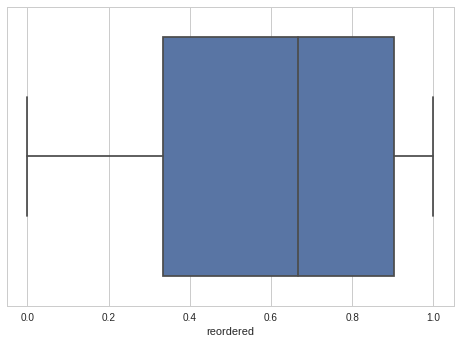

In [343]:
# sns.set(style="ticks")
# sns.boxplot(x="order_id", y="reordered", data=reorders_per_order)
#sns.despine(offset=10, trim=True)
sns.set_style("whitegrid")
ax = sns.boxplot(x=reorders_per_order["reordered"])

In [6]:
df1 = pd.merge(orders[['order_id', 'user_id']], order_products, on='order_id', how='left')
df2 = df1.groupby(['user_id', 'product_id'])['add_to_cart_order'].count().reset_index()
df2 = df2.rename(columns={'add_to_cart_order':'freq_count'})
df2

,user_id,product_id,freq_count
0,1,196.0,11
1,1,10258.0,10
2,1,10326.0,1
3,1,12427.0,10
4,1,13032.0,4
5,1,13176.0,2
6,1,14084.0,1
7,1,17122.0,1
8,1,25133.0,9
9,1,26088.0,3


In [7]:
df2 = df2.sort_values(['user_id', 'freq_count'], ascending=[True, False])
df2.product_id = df2.product_id.apply(lambda x: int(x))
df2.product_id = df2.product_id.astype(str)
df2

,user_id,product_id,freq_count
0,1,196,11
1,1,10258,10
3,1,12427,10
8,1,25133,9
4,1,13032,4
17,1,46149,4
9,1,26088,3
10,1,26405,3
18,1,49235,3
5,1,13176,2


In [240]:
df2.to_csv(PREPROCESSED_DATA_PATH + 'user_product_freqs.csv', index=False)

In [314]:
def model_threshold(threshold, orders_df):
    user_product_freqs = pd.read_csv(PREPROCESSED_DATA_PATH + 'user_product_freqs.csv')
    order_product_freqs = pd.merge(orders_df, user_product_freqs, on='user_id', how='left')
    temp_df = order_product_freqs.groupby('user_id').freq_count.max().reset_index().rename(columns={'freq_count':'thresh'})
    temp_df.thresh = temp_df.thresh * THRESHOLD

    def products(ids):
        return ' '.join(ids)

    temp2_df = pd.merge(order_product_freqs, temp_df, on='user_id', how='left')
    temp2_df = temp2_df[temp2_df.freq_count > temp2_df.thresh]    
    temp2_df.product_id = temp2_df.product_id.astype(str)
    submission_thresh_df = (temp2_df.groupby('order_id').product_id.agg([products]).reset_index())
    return submission_thresh_df

In [353]:
THRESHOLD = 0.33

test_order_ids = set(orders[orders['eval_set'] == 'test'].order_id.unique())
test_orders = orders[orders.order_id.isin(test_order_ids)]

# Calculate mean_basket_size per user
all_users_products = pd.merge(orders[orders.eval_set != 'test'], order_products, on='order_id', how='left')
test_order_product_count = all_users_products.groupby(['order_id', 'user_id']).product_id.count().reset_index().rename(columns={'product_id':'counts'})
test_order_product_count = test_order_product_count.sort_values(['user_id'])
test_user_basket_size = test_order_product_count.groupby('user_id').counts.mean().reset_index().rename(columns={'counts':'mean_basket_size'})
test_user_basket_size.mean_basket_size = test_user_basket_size.mean_basket_size.astype(int)
test_order_basket_size = pd.merge(test_orders, test_user_basket_size, on='user_id', how='left')
test_order_basket_size = test_order_basket_size[['order_id', 'mean_basket_size']]
test_order_basket_size
# Train on threshold model
test_submission_thresh_df = model_threshold(THRESHOLD, test_orders)

# Limit basket_size <= mean_basket_size
test_submission_thresh_df = pd.merge(test_submission_thresh_df, test_order_basket_size, on='order_id', how='left')

order_products_map = {}
for row in test_submission_thresh_df.itertuples(index=False):
    products = list(map(int, row.products.split(' ')))
    if len(products) > row.mean_basket_size:
        products = products[:row.mean_basket_size]
    products = list(map(str, products))
    order_products_map[row.order_id] = {'products': " ".join(products)}

test_submission_thresh_df = pd.DataFrame(order_products_map).T.reset_index().rename(columns={'index': 'order_id'})
test_submission_thresh_df.head()
timestamp = str(int(time.time()))
test_submission_thresh_df.to_csv(SUBMISSIONS_PATH + 'submission-' + timestamp + '.csv', index=False)
print('Created test submission file: ' + SUBMISSIONS_PATH + 'submission-' + timestamp + '.csv')

Created test submission file: /kaggle/dev/instacart-market-basket-analysis-data/submissions/submission-1497075115.csv


In [336]:
THRESHOLD = 0.35

train_order_ids = set(orders[orders['eval_set'] == 'train'].order_id.unique())
train_orders = orders[orders.order_id.isin(train_order_ids)]

# Calculate mean_basket_size per user
train_users_products = pd.merge(train_orders, order_products, on='order_id', how='left')
train_order_product_count = train_users_products.groupby(['order_id', 'user_id']).product_id.count().reset_index().rename(columns={'product_id':'counts'})
train_order_product_count = train_order_product_count.sort_values(['user_id'])
train_user_basket_size = train_order_product_count.groupby('user_id').counts.mean().reset_index().rename(columns={'counts':'mean_basket_size'})
train_user_basket_size.mean_basket_size = train_user_basket_size.mean_basket_size.astype(int)
train_order_basket_size = pd.merge(train_orders, train_user_basket_size, on='user_id', how='left')
train_order_basket_size = train_order_basket_size[['order_id', 'mean_basket_size']]

# Train on threshold model
train_submission_thresh_df = model_threshold(THRESHOLD, train_orders)

# Limit basket_size <= mean_basket_size
train_submission_thresh_df = pd.merge(train_submission_thresh_df, train_order_basket_size, on='order_id', how='left')

order_products_map = {}
for row in train_submission_thresh_df.itertuples(index=False):
    products = list(map(int, row.products.split(' ')))
    if len(products) > row.mean_basket_size:
        products = products[:row.mean_basket_size]
    products = list(map(str, products))
    order_products_map[row.order_id] = {'products': " ".join(products)}

train_submission_thresh_df = pd.DataFrame(order_products_map).T.reset_index().rename(columns={'index': 'order_id'})
train_submission_thresh_df.head()

,order_id,products
0,1,11109 14947 22035 43633 49302 5707 30881 44359
1,36,19660 20119 38293 42719 26629
2,38,8012 1940 21616 27344 33731 36322 47439
3,96,20574 24489 27966 29603 19904 39275 40706
4,98,19731 8859 37664 4357 15455 22963 34065 27509 ...


In [337]:
def performance(train_submission_df):
    # Evaluate performance
    metrics = {}
    precision_undefined_count = 0
    recall_undefined_count = 0
    f1_undefined_count = 0
    for row in train_true_submission_df.itertuples(index=False):
        y_true = set(map(int, row.products.split(' ')))
        train_order = train_submission_df[train_submission_df.order_id == row[0]].reset_index()
        if (len(train_order) == 0 or train_order.at[0, 'products'] == None):
            y_pred = set()
        else:
            y_pred = set(map(int, train_order.at[0, 'products'].split(' ')))    
        tp = len(y_true.intersection(y_pred))
        fp = len(y_pred - y_true)
        fn = len(y_true - y_pred)
        precision = None
        recall = None
        f1 = None
        if (tp+fp == 0.0):
            precision_undefined_count += 1
        else:
            precision = tp / (tp + fp)
        if (tp+fn == 0.0):
            recall_undefined_count += 1
        else:
            recall = tp / (tp + fn)
        if (precision == None or recall == None or precision+recall == 0.0):
            f1_undefined_count += 1
        else:
            f1 = 2 * precision * recall / (precision + recall)
        metrics[row[0]] = {'tp': tp, 'fp': fp, 'fn': fn, 'precision': precision, 'recall': recall, 'f1': f1,
                          'basket_size_diff': len(y_true) - len(y_pred), 'products_true': row.products}
    metrics_df = pd.DataFrame(metrics).T.reset_index().rename(columns={'index': 'order_id'})
    result_df = pd.merge(train_submission_df, metrics_df, on='order_id', how='left')
    timestamp = str(int(time.time()))
    result_df.to_csv(MODEL_PERFORMANCE_PATH + 'naive_model-' + timestamp + '.perf', index=False)
    print('Saved model performance data: ' + MODEL_PERFORMANCE_PATH + 'naive_model-' + timestamp + '.perf')
    print('Precision undefined count', precision_undefined_count)
    print('Recall undefined count', recall_undefined_count)
    print('F1 undefined_count', f1_undefined_count)
    print('F1 mean', result_df.f1.fillna(0).mean())
    result_df.head(10)

In [338]:
%%time
performance(train_submission_thresh_df)

Saved model performance data: /kaggle/dev/instacart-market-basket-analysis-data/model_performance_data/naive_model-1497073974.perf
Precision undefined count 0
Recall undefined count 0
F1 undefined_count 17815
F1 mean 0.385292135796
CPU times: user 2min 44s, sys: 664 ms, total: 2min 45s
Wall time: 2min 47s


In [340]:
perf_df = pd.read_csv('/kaggle/dev/instacart-market-basket-analysis-data/model_performance_data/naive_model-1497070696.perf')
perf_df.f1.fillna(0).mean()
# perf_df[perf_df.basket_size_diff > 0] - 52977 Predicted less items than true basket - 0.39393095323872807
# perf_df[perf_df.basket_size_diff == 0] - 10740 Predicted right amount of items - 0.52281760294180224
# perf_df[perf_df.basket_size_diff < 0] - 67492 Predicted more items than true basket - f1: 0.36396338631863095
# perf_df = perf_df.loc[perf_df.f1.isnull()]
# nan_orders_ids = set(perf_df.order_id.unique())
# #perf_df = perf_df.sort_values(['f1'], ascending=True)
# result_df = pd.merge(perf_df, train_true_submission_df, on='order_id', how='left')
# result_df

0.38906597897049822

In [341]:
perf_df2 = pd.read_csv('/kaggle/dev/instacart-market-basket-analysis-data/model_performance_data/naive_model-1497073974.perf')
perf_df2.f1.fillna(0).mean()

0.3852921357957525